In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from skimage.measure import label, regionprops

import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


data = pd.read_csv('../Data/train.csv')
train_lab1 = np.load('../Data/lab0.npy')
train_data1 = np.load('../Data/data0.npy')

n = train_data1.shape[0]
m = train_data1.shape[1]
k = train_data1.shape[2]

0  :  5
1  :  5
2  :  5
3  :  5
4  :  4
5  :  5
6  :  4
7  :  6
8  :  5
9  :  5
10  :  5
11  :  5
12  :  4
13  :  5
14  :  4
15  :  4
16  :  5
17  :  5
18  :  7
19  :  6
20  :  5
21  :  4
22  :  6
23  :  6
24  :  5
25  :  4
26  :  5
27  :  5
28  :  4
29  :  5
30  :  5
31  :  8
32  :  5
33  :  5
34  :  5
35  :  5
36  :  5
37  :  6
38  :  5
39  :  4
40  :  5
41  :  6
42  :  6
43  :  5
44  :  5
45  :  5
46  :  6
47  :  6
48  :  5
49  :  5
50  :  5
51  :  7
52  :  5
53  :  5
54  :  6
55  :  5
56  :  6
57  :  6
58  :  5
59  :  6
60  :  5
61  :  5
62  :  5
63  :  4
64  :  6
65  :  5
66  :  5
67  :  10
68  :  5
69  :  5
70  :  5
71  :  6
72  :  6
73  :  4
74  :  5
75  :  5
76  :  5
77  :  6
78  :  5
79  :  5
80  :  5
81  :  10
82  :  5
83  :  5
84  :  5
85  :  7
86  :  6
87  :  6
88  :  5
89  :  5
90  :  5
91  :  5
92  :  5
93  :  6
94  :  6
95  :  5
96  :  9
97  :  5
98  :  5
99  :  6


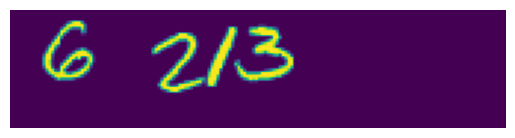

In [2]:

def img_conversion(img, threshold_value):
    m,n = img.shape
    for i in range(m):
        for j in range(n):
            x = img[i,j]
            img[i,j] = 0 if x <= threshold_value else 255

    return img

def get_labels_for_all_images(train_data):
    plt.imshow(train_data)
    plt.axis('off')
    image_file = 'img.png'
    plt.savefig(image_file)
    img = cv2.imread(image_file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_value = 125
    thresh = img_conversion(gray,threshold_value)
    labels = label(thresh,connectivity=thresh.ndim)
    return img, labels

def recognize_digits(train_data):
    digits_regions = []
    for i in range(len(train_data)):
        digregion = []
        img, labels = get_labels_for_all_images(train_data[i])
        regions = regionprops(labels)
        no_of_digits = 0
        for region in regions:
            row_min = region.bbox[0]
            row_max = region.bbox[2]
            col_min = region.bbox[1]
            col_max = region.bbox[3]
            cv2.rectangle(img, (col_min, row_min), (col_max, row_max), (0, 0, 255), 2)
            digregion.append(img[row_min:row_max, col_min:col_max])
            no_of_digits += 1
        digregion.pop(0)
        print(i, " : ", no_of_digits)
        digits_regions.append(digregion)

    return digits_regions

def padding_digits_regions(digits_regions):
    padding_digits_regions = []
    for i in range(len(digits_regions)):
        padd = []
        for j in range(len(digits_regions[i])):
            object = cv2.copyMakeBorder(digits_regions[i][j], 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[0, 0, 0])
            padd.append(object)
        padding_digits_regions.append(padd)
    return padding_digits_regions


def resizingImages(padding_digits_regions):
    size = (28,28)
    resizedImages = []
    for i in range(len(padding_digits_regions)):
        res = []
        for j in range(len(padding_digits_regions[i])):
            res.append(cv2.resize(padding_digits_regions[i][j], size))
        resizedImages.append(res)
    return resizedImages

resizedImages = resizingImages(padding_digits_regions(recognize_digits(train_data1[0:100])))

In [3]:
final_data = np.load('d0.npy',allow_pickle=True)

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-31 22:44:21.305834: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-31 22:44:21.305858: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
mnist_images = keras.datasets.mnist.load_data()
x_train = mnist_images[0][0].reshape(mnist_images[0][0].shape[0], 28, 28, 1).astype('float32') / 255
x_test = mnist_images[1][0].reshape(mnist_images[1][0].shape[0], 28, 28, 1).astype('float32') / 255
y_train = keras.utils.to_categorical(mnist_images[0][1], 10)
y_test = keras.utils.to_categorical(mnist_images[1][1], 10)

model.compile(optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),loss='categorical_crossentropy', metrics=['accuracy'])
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1,height_shift_range=0.1, zoom_range=0.1)
datagen.fit(x_train)
model.fit_generator(datagen.flow(x_train, y_train, batch_size=86), epochs=20)
model.save('modelMNIST.h5')

Epoch 1/20


/Users/sarthak/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/var/folders/y4/yphzsd_j3hbd5rzqwpdq7x9m0000gn/T/ipykernel_84274/2682710554.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(x_train, y_train, batch_size=86), epochs=20)
2023-01-31 22:44:21.833027: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-31 22:44:22.132584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


698/698 [==============================] - 15s 20ms/step - loss: 0.3719 - accuracy: 0.8837
Epoch 2/20
698/698 [==============================] - 14s 19ms/step - loss: 0.1317 - accuracy: 0.9604
Epoch 3/20
698/698 [==============================] - 14s 20ms/step - loss: 0.1016 - accuracy: 0.9697
Epoch 4/20
698/698 [==============================] - 14s 20ms/step - loss: 0.0884 - accuracy: 0.9747
Epoch 5/20
698/698 [==============================] - 14s 20ms/step - loss: 0.0810 - accuracy: 0.9766
Epoch 6/20
698/698 [==============================] - 14s 20ms/step - loss: 0.0754 - accuracy: 0.9782
Epoch 7/20
698/698 [==============================] - 14s 20ms/step - loss: 0.0737 - accuracy: 0.9783
Epoch 8/20
698/698 [==============================] - 14s 20ms/step - loss: 0.0701 - accuracy: 0.9798
Epoch 9/20
698/698 [==============================] - 14s 20ms/step - loss: 0.0704 - accuracy: 0.9793
Epoch 10/20
698/698 [==============================] - 14s 20ms/step - loss: 0.0697 - accurac

In [5]:

np.save('merged_array.npy', np.concatenate((np.load('d0.npy',allow_pickle=True), np.load('d1.npy',allow_pickle=True)), axis=0))
finalData=np.load("d0.npy",allow_pickle=True)
from keras.models import load_model
model = load_model('modelMNIST.h5')

accuracy = 0
i=0
while i<len(finalData):
    sum = 0
    j=0
    while j<len(finalData[i]):
        sum += np.argmax(model.predict(cv2.cvtColor(finalData[i][j], cv2.COLOR_BGR2GRAY).reshape(1, 28, 28, 1).astype('float32') / 255))
        j=j+1
    if sum == train_lab1[:200][i]:
        accuracy += 1
    i=i+1

print("Accuracy: ", accuracy/len(finalData)*100, "%")

1/1 [==============================] - 0s 13ms/step


2023-01-31 22:49:00.168214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step
Accuracy:  65.0 %
